In [1]:
import scanpy as sc
import muon as mu
import mofax as mofa
import mofapy2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import anndata as ad

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preprocessing

In [2]:
## read the data
Cite_data = sc.read_h5ad("/mnt/storage/thien/projectdata/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad")
print(Cite_data)

AnnData object with n_obs × n_vars = 90261 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [13]:
## the two modalities are stored in the same anndata object
set(Cite_data.var["feature_types"])

## prepare the dataset -> store data types in separate anndata objects within one dict
Cite_ADT = Cite_data[:,Cite_data.var["feature_types"]=="ADT"].copy()
Cite_GEX = Cite_data[:,Cite_data.var["feature_types"]=="GEX"].copy()

In [17]:
## store shared features for the GEX data, such that after variance filtering, these genes can again be added to the GEX data
shared_features = [name for name in list(Cite_ADT.var_names) if name in list(Cite_GEX.var_names)]
GEX_shared_features = Cite_GEX[:,shared_features] ### 

In [18]:
## preprocessing 
## ADT is already normalized, but with CLR instead of DSB --> ??
# scale 
sc.pp.scale(Cite_ADT)

# GEX 
## data is already normalized
# log transformation
sc.pp.log1p(Cite_GEX)

## filter for highly variable genes (threshold as in tutorial https://muon-tutorials.readthedocs.io/en/latest/cite-seq/1-CITE-seq-PBMC-5k.html)
sc.pp.highly_variable_genes(Cite_GEX,min_mean=0.02, max_mean=4, min_disp=0.5, inplace=True)
Cite_GEX = Cite_GEX[:, Cite_GEX.var.highly_variable]

## which shared features had been removed during variance filtering?
removed_shared_features = [name for name in list(GEX_shared_features.var_names) if name not in list(Cite_GEX.var_names)]
## add these again to the filtered GEX object
GEX_removed_features = GEX_shared_features[:,removed_shared_features] ### 
GEX_with_shared = ad.concat([ Cite_GEX, GEX_removed_features], axis = 1, merge="same")

## scale the data (z-transformation)
sc.pp.scale(GEX_with_shared)
# save preprocessed data 
#Cite_GEX.write_h5ad("/mnt/storage/anna/Cite_GEX_preprocessed.h5ad")
#Cite_ADT.write_h5ad("/mnt/storage/anna/Cite_ADT_preprocessed.h5ad")

/home/anna/.local/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [20]:
# save preprocessed data 
GEX_with_shared.write_h5ad("/mnt/storage/anna/Cite_GEX_with_shared_preprocessed_scaled.h5ad")
Cite_ADT.write_h5ad("/mnt/storage/anna/Cite_ADT_preprocessed_scaled.h5ad")

In [19]:
np.mean(GEX_with_shared.X, axis = 0)

array([-2.19784815e-05,  9.14391967e-06,  1.28374750e-05,  7.33540264e-06,
       -1.53836772e-05, -4.52132554e-05, -3.28006936e-05, -5.50015575e-05,
        2.44693256e-05,  7.60326511e-05,  1.89306866e-05, -3.55605662e-05,
       -1.57479208e-05,  2.36622727e-05, -1.37881580e-05,  1.71678366e-05,
       -3.47713576e-05,  1.95912089e-05,  2.24633322e-06, -4.70406630e-05,
       -5.27931297e-05,  1.07121787e-05, -2.37221029e-05,  5.86649821e-06,
       -2.86045315e-06, -1.11960126e-05, -4.12830241e-06,  9.60681427e-06,
        3.29607901e-05,  3.93970049e-06, -1.90869796e-05,  5.31305923e-05,
       -9.21421451e-05, -1.28803349e-05,  7.23188032e-06, -3.47070227e-06,
        1.47620594e-05,  1.01122587e-05,  1.37158386e-05, -1.42173667e-05,
       -2.35554344e-05, -4.80865237e-05, -1.26645209e-05,  1.76759731e-05,
        3.18348029e-05, -2.11203296e-05,  8.54953942e-06, -4.76870184e-07,
        1.67949838e-06,  1.23811305e-05,  3.65246779e-05,  4.98952977e-06,
        2.02431329e-05,  

/home/anna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


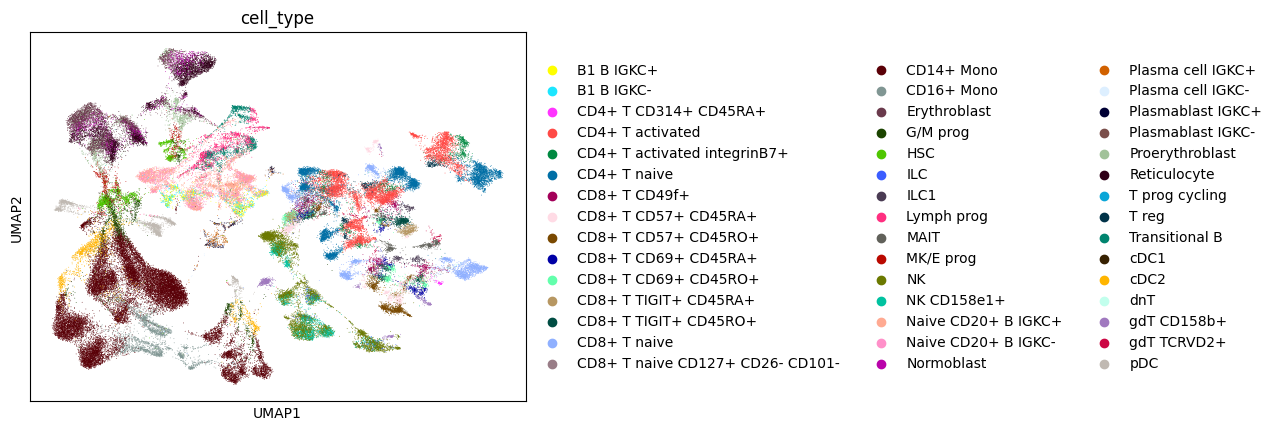

In [ ]:
#visualize in UMAP
sc.pp.pca(Cite_ADT)
sc.pp.neighbors(Cite_ADT, n_neighbors=15)
sc.tl.umap(Cite_ADT, random_state=1)#set random state to ensure reproducibility
sc.pl.umap(Cite_ADT, color="cell_type")


/home/anna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/anna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/anna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/anna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


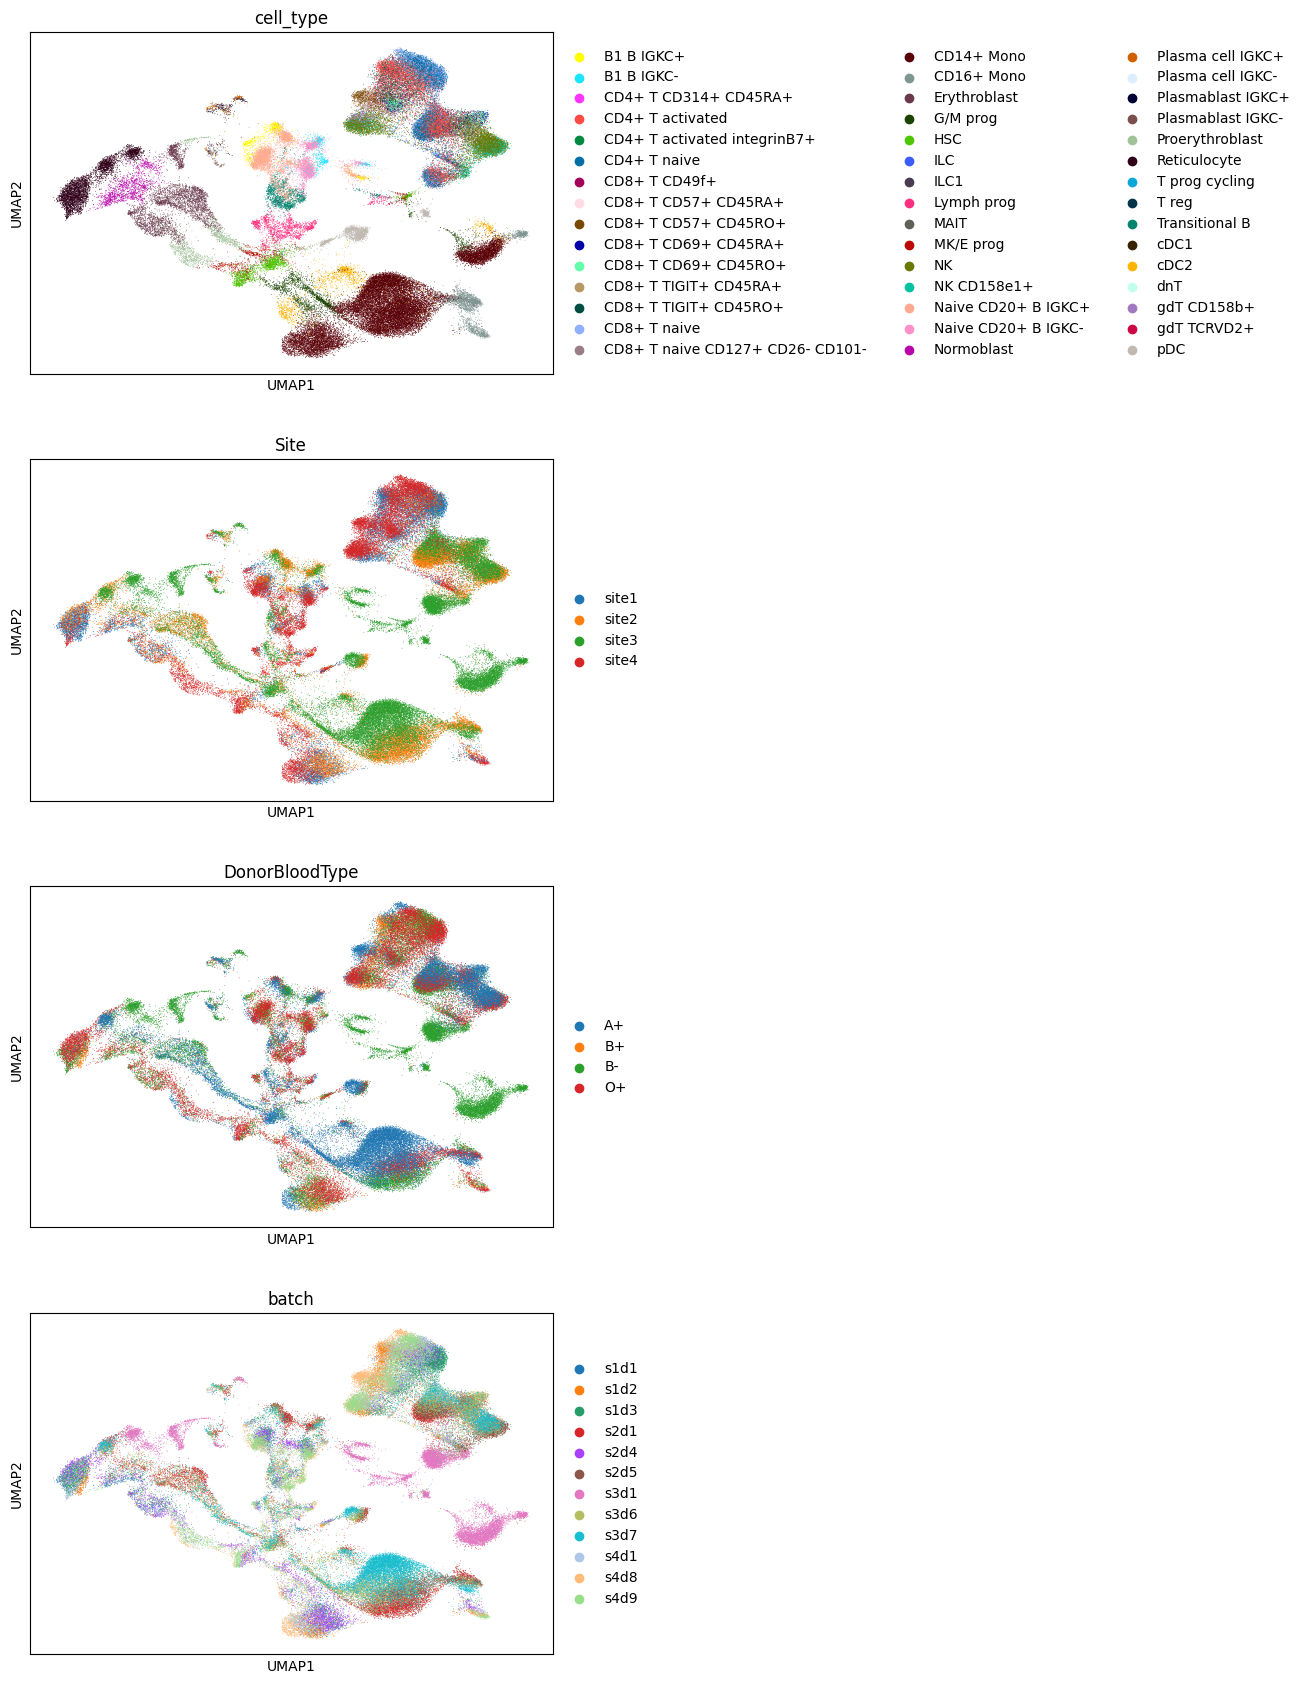

In [ ]:
#visualize in UMAP
#sc.pp.pca(Cite_GEX)
#sc.pp.neighbors(Cite_GEX, n_neighbors=15)
#sc.tl.umap(Cite_GEX, random_state=1)#set random state to ensure reproducibility
sc.pl.umap(Cite_GEX, color=["cell_type", "Site", "DonorBloodType", "batch"], ncols = 1)